In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


**Importing libraries**


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, accuracy_score,mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

**Importing data**

In [3]:
data_train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
data_test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')

**Data Understanding**

In [4]:
data_train.shape,data_test.shape

((6036000, 8), (4024000, 7))

In [5]:
data_train.columns

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')

In [6]:
data_train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [7]:
data_test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [8]:
data_train.value_counts()

id       breath_id  R   C   time_step  u_in      u_out  pressure
1        1          20  50  0.000000   0.083334  0      5.837492    1
4023997  83915      5   10  2.567509   4.977026  1      6.399909    1
4024006  83917      20  50  0.169514   3.232038  0      6.399909    1
4024005  83917      20  50  0.135577   1.007885  0      6.259305    1
4024004  83917      20  50  0.101689   0.000000  0      6.189002    1
                                                                   ..
2011999  41743      5   20  2.691778   4.988509  1      5.696887    1
2011998  41743      5   20  2.657701   4.986374  1      5.556283    1
2011997  41743      5   20  2.623264   4.983814  1      5.415679    1
2011996  41743      5   20  2.588044   4.980697  1      5.204772    1
6036000  125749     50  10  2.638017   1.482739  1      3.869032    1
Length: 6036000, dtype: int64

In [9]:
data_test.value_counts()

id       breath_id  R   C   time_step  u_in       u_out
1        0          5   20  0.000000   0.000000   0        1
2682658  83732      20  50  0.586017   28.390826  0        1
2682660  83732      20  50  0.655317   28.295062  0        1
2682661  83732      20  50  0.689406   27.674431  0        1
2682662  83732      20  50  0.723482   26.297969  0        1
                                                          ..
1341338  42202      50  50  1.963689   4.526287   1        1
1341339  42202      50  50  1.998020   4.601005   1        1
1341340  42202      50  50  2.032874   4.664816   1        1
1341341  42202      50  50  2.066813   4.717131   1        1
4024000  125748     20  10  2.665301   4.985373   1        1
Length: 4024000, dtype: int64

**Missing values**


In [10]:
data_train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [11]:
data_train.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [12]:
data_test.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
dtype: int64

In [13]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [14]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024000 entries, 0 to 4023999
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
dtypes: float64(2), int64(5)
memory usage: 214.9 MB


In [15]:
data_train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


**Exploratory Data Analysis**

In [16]:
#numerical data columns
features = data_train.select_dtypes(include = [np.number])
features

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


In [17]:
correlation = features.corr()
print(correlation['pressure'].sort_values(ascending = False),'\n')

pressure     1.000000
u_in         0.308136
R            0.015976
breath_id   -0.002394
id          -0.002402
C           -0.036727
time_step   -0.524829
u_out       -0.614910
Name: pressure, dtype: float64 



<AxesSubplot:>

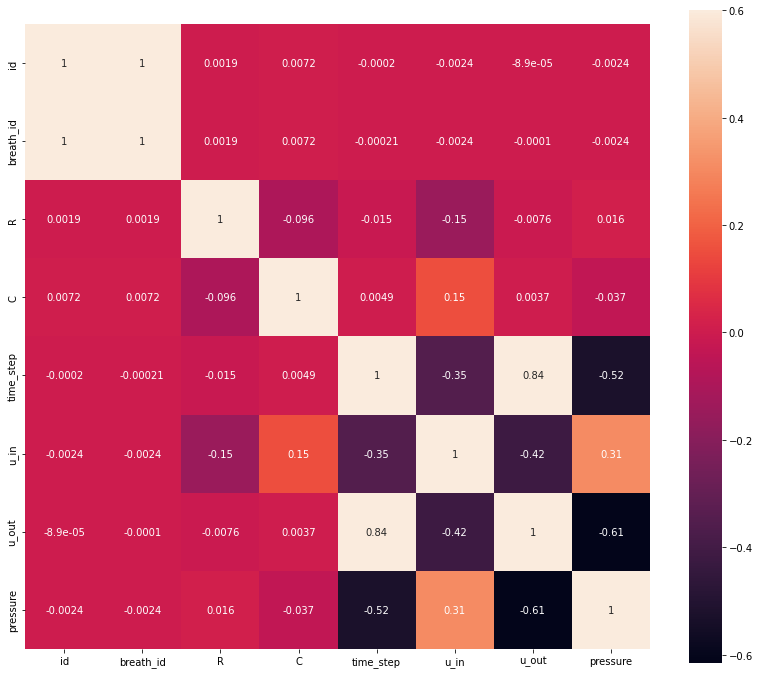

In [18]:
f,ax = plt.subplots(figsize = (14,12))
sns.heatmap(correlation,square = True,vmax = 0.6,annot = True)


From the heat map we can observe that there is a multicollinearity between id and breathe_id, so we need to drop any one of the column to increase the performance of the model.

pressure is highly correlated with u_out and time_step

**dropping the id column**

In [19]:
data_train = data_train.drop(['id'], axis = 1)
data_test = data_test.drop(['id'], axis = 1)

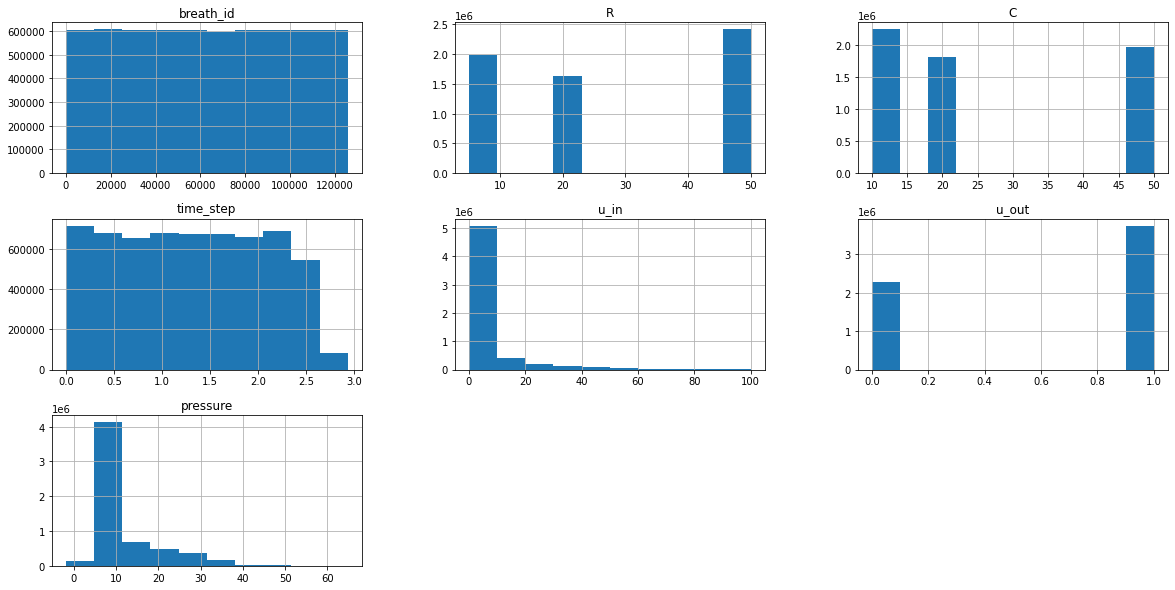

In [20]:
eda_columns = ['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure']
data_train[eda_columns].hist(figsize = (20,10))
plt.show()

In [21]:
set(data_train['R'])

{5, 20, 50}

In [22]:
set(data_test['R'])

{5, 20, 50}

In [23]:
set(data_train['C'])

{10, 20, 50}

In [24]:
set(data_test['C'])

{10, 20, 50}

Variable 'R', 'C' and 'u_out' are categorical variables here as we can see in above graphs.

**Data splitting**

In [25]:
data_train_copy = data_train.copy()
X = data_train_copy.drop(columns='pressure')
y = data_train_copy['pressure']

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2,random_state = 1)

In [27]:
X_train.shape,Y_train.shape

((4828800, 6), (4828800,))

In [28]:
X_test.shape,Y_test.shape

((1207200, 6), (1207200,))

**Model Building**

**MAPE function**

In [29]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

**Linear Regression**

In [30]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()

LR_model.fit(X_train, Y_train)

LR_train_predict = LR_model.predict(X_train)
LR_test_predict = LR_model.predict(X_test)

In [31]:
LR_R2_train = r2_score(Y_train,LR_train_predict)
LR_R2_test = r2_score(Y_test,LR_test_predict)

LR_MAPE_train = mape(Y_train,LR_train_predict)
LR_MAPE_test = mape(Y_test,LR_test_predict)

LR_MAE_test = mean_absolute_error(Y_test,LR_test_predict)
LR_MAE_train = mean_absolute_error(Y_train,LR_train_predict)

In [32]:
print("train r2_score : ",LR_R2_train)
print("test r2_score : ",LR_R2_test)


print("train mape score : ",LR_MAPE_train)
print("test mape score : ",LR_MAPE_test)

print("train MAE score :",LR_MAE_train)
print("test MAE score :",LR_MAE_test)

train r2_score :  0.38430500472192
test r2_score :  0.382336811448047
train mape score :  48.856114288854776
test mape score :  51.709911534728604
train MAE score : 3.9464568555827375
test MAE score : 3.9545090843780573


In [33]:
LR_model_score_train = LR_model.score(X_train, Y_train)
LR_model_score_test = LR_model.score(X_test, Y_test)
print(LR_model_score_train,LR_model_score_test)

0.38430500472192 0.382336811448047


In [34]:
resultsLR_train = pd.DataFrame({'R Squared Score': LR_R2_train,
                          'MAPE Score':LR_MAPE_train,
                         'MAE Score':LR_MAE_train,
                         'Model Score':LR_model_score_train}
                           ,index=['Linear Regression'])

resultsLR_train

,R Squared Score,MAPE Score,MAE Score,Model Score
Linear Regression,0.384305,48.856114,3.946457,0.384305


In [35]:
resultsLR_test = pd.DataFrame({'R Squared Score': LR_R2_test,
                          'MAPE Score':LR_MAPE_test,
                         'MAE Score':LR_MAE_test,
                         'Model Score':LR_model_score_test}
                           ,index=['Linear Regression'])

resultsLR_test

,R Squared Score,MAPE Score,MAE Score,Model Score
Linear Regression,0.382337,51.709912,3.954509,0.382337


**Decison Tree**

In [36]:
from sklearn.tree import DecisionTreeRegressor
DT_model = DecisionTreeRegressor(max_depth = 10,min_weight_fraction_leaf = 0.01,random_state = 0)

DT_model.fit(X_train, Y_train)

DT_pred_train = DT_model.predict(X_train)
DT_pred_test = DT_model.predict(X_test)

In [37]:
DT_R2_train = r2_score(Y_train,DT_pred_train)
DT_R2_test = r2_score(Y_test,DT_pred_test)

DT_MAPE_train = mape(Y_train,DT_pred_train)
DT_MAPE_test = mape(Y_test,DT_pred_test)

DT_MAE_test = mean_absolute_error(Y_test,DT_pred_test)
DT_MAE_train = mean_absolute_error(Y_train,DT_pred_train)

In [38]:
print("train r2_score : ",DT_R2_train)
print("test r2_score : ",DT_R2_test)


print("train mape score : ",DT_MAPE_train)
print("test mape score : ",DT_MAPE_test)

print("train MAE score :",DT_MAE_train)
print("test MAE score :",DT_MAE_test)

train r2_score :  0.6581593033771412
test r2_score :  0.6573058747373273
train mape score :  32.2783962090603
test mape score :  34.66763388575755
train MAE score : 2.603045955345301
test MAE score : 2.6090337526088496


In [39]:
DT_model_score_test = DT_model.score(X_test, Y_test)
DT_model_score_train = DT_model.score(X_train, Y_train)
print(DT_model_score_train, DT_model_score_test)

0.6581593033771412 0.6573058747373273


In [40]:
resultsDT_train = pd.DataFrame({'R Squared Score': DT_R2_train,
                          'MAPE Score':DT_MAPE_train,
                            'MAE Score':DT_MAE_train,
                         'Model Score':DT_model_score_train}
                           ,index=['Decision Tree Regressor'])

results2_train = pd.concat([resultsDT_train,resultsLR_train])

results2_train

,R Squared Score,MAPE Score,MAE Score,Model Score
Decision Tree Regressor,0.658159,32.278396,2.603046,0.658159
Linear Regression,0.384305,48.856114,3.946457,0.384305


In [41]:
resultsDT_test = pd.DataFrame({'R Squared Score': DT_R2_test,
                          'MAPE Score':DT_MAPE_test,
                            'MAE Score':DT_MAE_test,
                         'Model Score':DT_model_score_test}
                           ,index=['Decision Tree Regressor'])

results2_test = pd.concat([resultsDT_test,resultsLR_test])

results2_test

,R Squared Score,MAPE Score,MAE Score,Model Score
Decision Tree Regressor,0.657306,34.667634,2.609034,0.657306
Linear Regression,0.382337,51.709912,3.954509,0.382337


**Random Forest**

In [42]:
'''RF_model=RandomForestRegressor(n_estimators = 501, random_state=0)
RF_model.fit(X_train, Y_train)'''

'RF_model=RandomForestRegressor(n_estimators = 501, random_state=0)\nRF_model.fit(X_train, Y_train)'

In [43]:
#RF_train_pred = RF_model.predict(X_train)
#RF_test_pred = RF_model.predict(X_test)

In [44]:
'''RF_R2_train = r2_score(Y_train,RF_train_predict)
RF_R2_test = r2_score(Y_test,RF_test_predict)

RF_MAPE_train = mape(Y_train,RF_train_predict)
RF_MAPE_test = mape(Y_test,RF_test_predict)

RF_MAE_test = mean_absolute_error(Y_test,RF_test_predict)
RF_MAE_train = mean_absolute_error(Y_train,RF_train_predict)'''

'RF_R2_train = r2_score(Y_train,RF_train_predict)\nRF_R2_test = r2_score(Y_test,RF_test_predict)\n\nRF_MAPE_train = mape(Y_train,RF_train_predict)\nRF_MAPE_test = mape(Y_test,RF_test_predict)\n\nRF_MAE_test = mean_absolute_error(Y_test,RF_test_predict)\nRF_MAE_train = mean_absolute_error(Y_train,RF_train_predict)'

In [45]:
'''print("train r2_score : ",RF_R2_train)
print("test r2_score : ",RF_R2_test)


print("train mape score : ",RF_MAPE_train)
print("test mape score : ",RF_MAPE_test)

print("train MAE score :",RF_MAE_train)
print("test MAE score :",RF_MAE_test)'''

'print("train r2_score : ",RF_R2_train)\nprint("test r2_score : ",RF_R2_test)\n\n\nprint("train mape score : ",RF_MAPE_train)\nprint("test mape score : ",RF_MAPE_test)\n\nprint("train MAE score :",RF_MAE_train)\nprint("test MAE score :",RF_MAE_test)'

**XGBoost Regressor**

In [46]:
XGB_model = XGBRegressor()
XGB_model.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [47]:
XGB_pred_test = XGB_model.predict(X_test)
XGB_pred_train = XGB_model.predict(X_train)

In [48]:
XGB_MAPE_test = mean_absolute_error(Y_test,XGB_pred_test)
XGB_MAPE_train = mean_absolute_error(Y_train,XGB_pred_train)

XGB_R2_train = r2_score(Y_train,XGB_pred_train)
XGB_R2_test = r2_score(Y_test,XGB_pred_test)

XGB_MAE_test = mean_absolute_error(Y_test,XGB_pred_test)
XGB_MAE_train = mean_absolute_error(Y_train,XGB_pred_train)

In [49]:
print("train r2_score : ",XGB_R2_train)
print("test r2_score : ",XGB_R2_test)


print("train mape score : ",XGB_MAPE_train)
print("test mape score : ",XGB_MAPE_test)

print("train MAE score :",XGB_MAE_train)
print("test MAE score :",XGB_MAE_test)

train r2_score :  0.7402143476833369
test r2_score :  0.7385453714793443
train mape score :  2.1290010083623336
test mape score :  2.1369924502317774
train MAE score : 2.1290010083623336
test MAE score : 2.1369924502317774


In [50]:
XGB_model_score_test = XGB_model.score(X_test,Y_test)
XGB_model_score_train = XGB_model.score(X_train,Y_train)
print(XGB_model_score_train,XGB_model_score_test)

0.7402143476833369 0.7385453714793443


In [51]:
resultsXGB_train = pd.DataFrame({'R Squared Score': XGB_R2_train,
                          'MAPE Score':XGB_MAPE_train,
                            'MAE Score':XGB_MAE_train,
                         'Model Score':XGB_model_score_train}
                           ,index=['XGBoost Regressor'])

results2_train = pd.concat([resultsLR_train,resultsDT_train,resultsXGB_train])

results2_train

,R Squared Score,MAPE Score,MAE Score,Model Score
Linear Regression,0.384305,48.856114,3.946457,0.384305
Decision Tree Regressor,0.658159,32.278396,2.603046,0.658159
XGBoost Regressor,0.740214,2.129001,2.129001,0.740214


In [52]:
resultsXGB_test = pd.DataFrame({'R Squared Score': XGB_R2_test,
                          'MAPE Score':XGB_MAPE_test,
                            'MAE Score':XGB_MAE_test,
                         'Model Score':XGB_model_score_test}
                           ,index=['XGBoost Regressor'])

results2_test = pd.concat([resultsLR_test,resultsDT_test,resultsXGB_test])

results2_test

,R Squared Score,MAPE Score,MAE Score,Model Score
Linear Regression,0.382337,51.709912,3.954509,0.382337
Decision Tree Regressor,0.657306,34.667634,2.609034,0.657306
XGBoost Regressor,0.738545,2.136992,2.136992,0.738545


**Light Gradient Boosted Machine regressor (LGBM Regressor)**

In [53]:
import lightgbm as lgb
lgb = make_pipeline(StandardScaler(),lgb.LGBMRegressor(learning_rate = 0.01,n_estimators = 600))

In [54]:
lgb.fit(X_train,Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmregressor',
                 LGBMRegressor(learning_rate=0.01, n_estimators=600))])

In [55]:
lgb_pred_test = lgb.predict(X_test)
lgb_pred_train = lgb.predict(X_train)

In [56]:
lgb_MAPE_test = mean_absolute_error(Y_test,lgb_pred_test)
lgb_MAPE_train = mean_absolute_error(Y_train,lgb_pred_train)

lgb_R2_train = r2_score(Y_train,lgb_pred_train)
lgb_R2_test = r2_score(Y_test,lgb_pred_test)

lgb_MAE_test = mean_absolute_error(Y_test,lgb_pred_test)
lgb_MAE_train = mean_absolute_error(Y_train,lgb_pred_train)

In [57]:
print("train r2_score : ",lgb_R2_train)
print("test r2_score : ",lgb_R2_test)


print("train mape score : ",lgb_MAPE_train)
print("test mape score : ",lgb_MAPE_test)

print("train MAE score :",lgb_MAE_train)
print("test MAE score :",lgb_MAE_test)

train r2_score :  0.7416235586617452
test r2_score :  0.740330679371344
train mape score :  2.158004146586652
test mape score :  2.1647655530486585
train MAE score : 2.158004146586652
test MAE score : 2.1647655530486585


In [58]:
lgb_model_score_test = lgb.score(X_test, Y_test)
lgb_model_score_train = lgb.score(X_train, Y_train)
print(lgb_model_score_train,lgb_model_score_test)

0.7416235586617452 0.740330679371344


In [59]:
resultsLGBMR_train = pd.DataFrame({'R Squared Score': lgb_R2_train,
                          'MAPE Score':lgb_MAPE_train,
                            'MAE Score':lgb_MAE_train,
                         'Model Score':lgb_model_score_train}
                           ,index=['Light Gradient Boosted Machine'])

results3_train = pd.concat([resultsLR_train,resultsDT_train,resultsXGB_train,resultsLGBMR_train])

results3_train

,R Squared Score,MAPE Score,MAE Score,Model Score
Linear Regression,0.384305,48.856114,3.946457,0.384305
Decision Tree Regressor,0.658159,32.278396,2.603046,0.658159
XGBoost Regressor,0.740214,2.129001,2.129001,0.740214
Light Gradient Boosted Machine,0.741624,2.158004,2.158004,0.741624


In [60]:
resultsLGBMR_test = pd.DataFrame({'R Squared Score': lgb_R2_test,
                          'MAPE Score':lgb_MAPE_test,
                            'MAE Score':lgb_MAE_test,
                         'Model Score':lgb_model_score_test}
                           ,index=['Light Gradient Boosted Machine'])

results3_test = pd.concat([resultsLR_test,resultsDT_test,resultsXGB_test,resultsLGBMR_test])

results3_test

,R Squared Score,MAPE Score,MAE Score,Model Score
Linear Regression,0.382337,51.709912,3.954509,0.382337
Decision Tree Regressor,0.657306,34.667634,2.609034,0.657306
XGBoost Regressor,0.738545,2.136992,2.136992,0.738545
Light Gradient Boosted Machine,0.740331,2.164766,2.164766,0.740331


**CatBoost Regressor**

In [61]:
from catboost import CatBoostRegressor
cbr = CatBoostRegressor(learning_rate=0.1, max_depth=10, n_estimators=900, subsample=0.5)
cbr.fit(X_train, Y_train)

0:	learn: 7.5813080	total: 825ms	remaining: 12m 21s
1:	learn: 7.1223558	total: 1.38s	remaining: 10m 18s
2:	learn: 6.7128979	total: 1.91s	remaining: 9m 31s
3:	learn: 6.3575901	total: 2.58s	remaining: 9m 39s
4:	learn: 6.0585822	total: 3.19s	remaining: 9m 31s
5:	learn: 5.7990856	total: 3.79s	remaining: 9m 24s
6:	learn: 5.5677793	total: 4.33s	remaining: 9m 13s
7:	learn: 5.3701370	total: 4.84s	remaining: 8m 59s
8:	learn: 5.2049695	total: 5.33s	remaining: 8m 48s
9:	learn: 5.0606163	total: 5.83s	remaining: 8m 39s
10:	learn: 4.9403205	total: 6.33s	remaining: 8m 31s
11:	learn: 4.8390641	total: 6.83s	remaining: 8m 25s
12:	learn: 4.7485741	total: 7.41s	remaining: 8m 25s
13:	learn: 4.6738004	total: 7.97s	remaining: 8m 24s
14:	learn: 4.6083828	total: 8.47s	remaining: 8m 19s
15:	learn: 4.5520398	total: 8.98s	remaining: 8m 16s
16:	learn: 4.5049548	total: 9.48s	remaining: 8m 12s
17:	learn: 4.4637493	total: 10s	remaining: 8m 10s
18:	learn: 4.4274024	total: 10.5s	remaining: 8m 7s
19:	learn: 4.3971078	to

In [62]:
cat_pred_test = cbr.predict(X_test)
cat_pred_train = cbr.predict(X_train)

In [63]:
cat_MAPE_test = mean_absolute_error(Y_test,cat_pred_test)
cat_MAPE_train = mean_absolute_error(Y_train,cat_pred_train)

cat_R2_train = r2_score(Y_train,cat_pred_train)
cat_R2_test = r2_score(Y_test,cat_pred_test)

cat_MAE_test = mean_absolute_error(Y_test,cat_pred_test)
cat_MAE_train = mean_absolute_error(Y_train,cat_pred_train)

In [64]:
print("train r2_score : ",cat_R2_train)
print("test r2_score : ",cat_R2_test)

print("train mape score : ",cat_MAPE_train)
print("test mape score : ",cat_MAPE_test)

print("train MAE score :",cat_MAE_train)
print("test MAE score :",cat_MAE_test)

cat_model_score_test = cbr.score(X_test, Y_test)
cat_model_score_train = cbr.score(X_train, Y_train)
print(cat_model_score_train,cat_model_score_test)

train r2_score :  0.775036683672321
test r2_score :  0.7726600493483693
train mape score :  1.9637596887695312
test mape score :  1.9739024725494316
train MAE score : 1.9637596887695312
test MAE score : 1.9739024725494316
0.775036683672321 0.7726600493483693


In [65]:
resultsCBR_train = pd.DataFrame({'R Squared Score': cat_R2_train,
                          'MAPE Score':cat_MAPE_train,
                            'MAE Score':cat_MAE_train,
                         'Model Score':cat_model_score_train}
                           ,index=['CatBoost Regressor'])

results4_train = pd.concat([resultsLR_train,resultsDT_train,resultsXGB_train,resultsLGBMR_train,resultsCBR_train])

results4_train

,R Squared Score,MAPE Score,MAE Score,Model Score
Linear Regression,0.384305,48.856114,3.946457,0.384305
Decision Tree Regressor,0.658159,32.278396,2.603046,0.658159
XGBoost Regressor,0.740214,2.129001,2.129001,0.740214
Light Gradient Boosted Machine,0.741624,2.158004,2.158004,0.741624
CatBoost Regressor,0.775037,1.963760,1.963760,0.775037


In [66]:
resultsCBR_test = pd.DataFrame({'R Squared Score': cat_R2_test,
                          'MAPE Score':cat_MAPE_test,
                            'MAE Score':cat_MAE_test,
                         'Model Score':cat_model_score_test}
                           ,index=['CatBoost Regressor'])

results4_test = pd.concat([resultsLR_test,resultsDT_test,resultsXGB_test,resultsLGBMR_test,resultsCBR_test])

results4_test

,R Squared Score,MAPE Score,MAE Score,Model Score
Linear Regression,0.382337,51.709912,3.954509,0.382337
Decision Tree Regressor,0.657306,34.667634,2.609034,0.657306
XGBoost Regressor,0.738545,2.136992,2.136992,0.738545
Light Gradient Boosted Machine,0.740331,2.164766,2.164766,0.740331
CatBoost Regressor,0.772660,1.973902,1.973902,0.772660


**Submission**

In [67]:
Submission = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

In [68]:
data_test.columns

Index(['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out'], dtype='object')

In [69]:
#data_test.drop(columns=['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out'], axis = 1, inplace = True)
Final_Prediction = cbr.predict(data_test)

In [70]:
Submission.pressure = Final_Prediction
Submission.head()

,id,pressure
0,1,6.322274
1,2,6.188501
2,3,7.105514
3,4,8.132160
4,5,9.845394


In [71]:
Submission.to_csv("submission.csv", index=False)

**Deployement**

In [72]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 KB 42.5 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4712 sha256=26eb946323f406a5d8c78103ca8455688e88d609d708303886b88ca9cb765668
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel f

In [73]:
import gradio as gr
import warnings
warnings.filterwarnings('ignore')

In [74]:
def pressure(breath_id, R, C, time_step, u_in, u_out):
    x = np.array([breath_id, R, C, time_step, u_in, u_out])
    prediction = DT_model.predict(x.reshape(1,-1))
    return prediction

In [75]:
outputs = gr.outputs.Textbox()
app = gr.Interface(fn = pressure,inputs = ['number','number','number','number','number','number'],outputs = outputs,description = "pressure prediction" )

In [76]:
app.launch(share = True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://54381.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f34e8ffdf90>,
 'http://127.0.0.1:7860/',
 'https://54381.gradio.app')